## Machine Translation
**Using mt_eng_vietnamese dataset**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "datasets" "contractions"

In [ ]:
import datasets
import string
import contractions
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from urllib.parse import urljoin

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Input, RepeatVector, SimpleRNN, Dense, LSTM, GRU, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.callbacks import ModelCheckpoint

In [ ]:
source_path = "/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/"

### 1.Prepare dataset

**Down load from datasets**

In [ ]:
corpus = datasets.load_dataset("mt_eng_vietnamese", "iwslt2015-en-vi")

Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Dataset mt_eng_vietnamese downloaded and prepared to /root/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
corpus

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 133318
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
})

In [ ]:
def preprocess_text(text, en=False):
    if en:
        text = text.replace("&quot;", " ")
        text = text.replace(" &apos;", "'")
        text = contractions.fix(text)
    text = text.lower()
    punc_number = list(string.punctuation + string.digits)
    for c in punc_number:
        text = text.replace(c, " ")
    return " ".join(text.split())
preprocess_text("I'll...2 35!", True)

'i will'

In [ ]:
en_corpus = []
vi_corpus = []
for data in corpus['train']:
    en_corpus.append(preprocess_text("startseq " + data['translation']['en'] + " endseq", en=True))
    vi_corpus.append(preprocess_text("startseq " + data['translation']['vi'] + " endseq"))

In [ ]:
vi_corpus[0], en_corpus[0]

('startseq khoa học đằng sau một tiêu đề về khí hậu endseq',
 'startseq rachel pike the science behind a climate headline endseq')

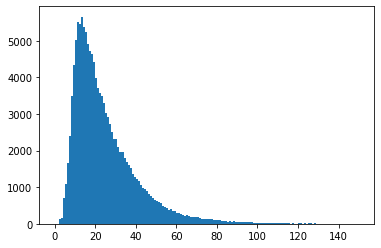

In [ ]:
plt.hist([len(t.split()) for t in vi_corpus], bins=150, range=(0, 150))
plt.show()

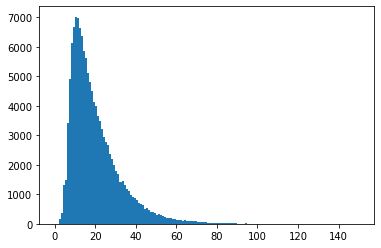

In [ ]:
plt.hist([len(t.split()) for t in en_corpus], bins=150, range=(0, 150))
plt.show()

In [ ]:
vi_max_len = 100
en_max_len = 80

In [ ]:
vi_train, vi_test, en_train, en_test = train_test_split(vi_corpus, en_corpus, test_size=0.3, random_state=42)
vi_valid, vi_test, en_valid, en_test = train_test_split(vi_test, en_test, test_size=0.5, random_state=42)

In [ ]:
len(vi_train), len(vi_valid), len(vi_test)

(93322, 19998, 19998)

In [ ]:
vi_data, en_data, type_data = [], [], []
for vi, en in zip(vi_train, en_train):
    vi_data.append(vi)
    en_data.append(en)
    type_data.append("train")
for vi, en in zip(vi_valid, en_valid):
    vi_data.append(vi)
    en_data.append(en)
    type_data.append("valid")
for vi, en in zip(vi_test, en_test):
    vi_data.append(vi)
    en_data.append(en)
    type_data.append("test")

In [ ]:
df = pd.DataFrame()
df["vi"] = vi_data
df["en"] = en_data
df["type_data"] = type_data

In [ ]:
df

,vi,en,type_data
0,startseq lúc đó ngồi cạnh tôi là một học sinh ...,startseq and in the seat next to me was a high...,train
1,startseq và tôi nghĩ theo thời gian những năm ...,startseq and i think with time in the years to...,train
2,startseq liệu có đúng không nếu đánh giá một n...,startseq is not the measure of a man his willi...,train
3,startseq đèn đỏ giao thông có bảng đếm ngược e...,startseq red traffic lights have a countdown d...,train
4,startseq nhưng làm sao chúng làm được điều đó ...,startseq but how do we do that endseq,train
...,...,...,...
133313,startseq cho phép tôi tinh giảm điều này tới m...,startseq and let me reduce this to the simples...,test
133314,startseq các bạn đều biết twitter và các phiên...,startseq you know twitter and twitter clones h...,test
133315,startseq nguồn tài chính quan trọng không kém ...,startseq the supply of money — just as importa...,test
133316,startseq ở tuổi tôi đã tuyển những người từ đạ...,startseq at the age of i was recruiting people...,test


**Save fix train/validation/test set**

In [ ]:
df.to_csv(urljoin(source_path, "save_model/machine_translation_eng_vietnamese.csv"), index=False)

In [ ]:
df = pd.read_csv(urljoin(source_path, "save_model/machine_translation_eng_vietnamese.csv"))

In [ ]:
df

,vi,en,type_data
0,startseq lúc đó ngồi cạnh tôi là một học sinh ...,startseq and in the seat next to me was a high...,train
1,startseq và tôi nghĩ theo thời gian những năm ...,startseq and i think with time in the years to...,train
2,startseq liệu có đúng không nếu đánh giá một n...,startseq is not the measure of a man his willi...,train
3,startseq đèn đỏ giao thông có bảng đếm ngược e...,startseq red traffic lights have a countdown d...,train
4,startseq nhưng làm sao chúng làm được điều đó ...,startseq but how do we do that endseq,train
...,...,...,...
133313,startseq cho phép tôi tinh giảm điều này tới m...,startseq and let me reduce this to the simples...,test
133314,startseq các bạn đều biết twitter và các phiên...,startseq you know twitter and twitter clones h...,test
133315,startseq nguồn tài chính quan trọng không kém ...,startseq the supply of money — just as importa...,test
133316,startseq ở tuổi tôi đã tuyển những người từ đạ...,startseq at the age of i was recruiting people...,test


In [ ]:
vi_train, en_train = df[df.type_data == "train"].vi, df[df.type_data == "train"].en
vi_valid, en_valid = df[df.type_data == "valid"].vi, df[df.type_data == "valid"].en
vi_test, en_test = df[df.type_data == "test"].vi, df[df.type_data == "test"].en

### 2.Feature Extraction

In [ ]:
vi_max_len = 100
en_max_len = 80

In [ ]:
def encode_sequences(tokenizer, max_len, corpus, is_seq2seq=False):
    if not is_seq2seq:
        seqs = tokenizer.texts_to_sequences(corpus)
        padded_seqs = pad_sequences(seqs, maxlen=max_len, 
                                    padding='post', 
                                    truncating='post')
        return padded_seqs
    else:
        seqs = tokenizer.texts_to_sequences(corpus)
        padded_seqs = pad_sequences(seqs, 
                                    maxlen=max_len, 
                                    padding='post', 
                                    truncating='post')

        output_corpus = [" ".join(i.split()[1:]) for i in corpus]
        output_seqs = tokenizer.texts_to_sequences(output_corpus)
        output_padded_seqs = pad_sequences(output_seqs, 
                                           maxlen=max_len, 
                                           padding='post', 
                                           truncating='post')
        return padded_seqs, output_padded_seqs

def encode_outputs(seqs, vocab_size):
    padded_seqs = to_categorical(seqs, en_vocab_size )
    padded_seqs = np.array(padded_seqs)
    padded_seqs = padded_seqs.reshape(seqs.shape[0], seqs.shape[1], vocab_size)
    return padded_seqs

In [ ]:
vi_tokenizer = Tokenizer(oov_token = '<OOV>')
vi_tokenizer.fit_on_texts(vi_train)
vi_word_dict = vi_tokenizer.word_index
vi_vocab_size = len(vi_word_dict) + 1
vi_vocab_size

16055

In [ ]:
vi_train_padded_seqs = encode_sequences(vi_tokenizer, vi_max_len, vi_train)
vi_valid_padded_seqs = encode_sequences(vi_tokenizer, vi_max_len, vi_valid)
vi_train_padded_seqs.shape, vi_valid_padded_seqs.shape

((93322, 100), (19998, 100))

In [ ]:
en_tokenizer = Tokenizer(oov_token = '<OOV>')
en_tokenizer.fit_on_texts(en_train)
en_word_dict = en_tokenizer.word_index
en_vocab_size = len(en_tokenizer.index_word) + 1
en_vocab_size

36256

In [ ]:
en_train_padded_seqs = encode_sequences(en_tokenizer, en_max_len, en_train)
en_valid_padded_seqs = encode_sequences(en_tokenizer, en_max_len, en_valid)
en_train_padded_seqs.shape, en_valid_padded_seqs.shape

((93322, 80), (19998, 80))

In [ ]:
def generate_encode_batch(src_input_seqs, tgt_output_seqs, batch_size, vocab_size):
    while True:
        for j in range(0, len(src_input_seqs), batch_size):
            src_input_seq = src_input_seqs[j:j+batch_size]
            tgt_output_seq = tgt_output_seqs[j:j+batch_size]
            tgt_output_seq = encode_outputs(tgt_output_seq, vocab_size)

            src_input_seq = np.array(src_input_seq)
            tgt_output_seq = np.array(tgt_output_seq)
            yield (src_input_seq, tgt_output_seq)

In [ ]:
encode_batch = generate_encode_batch(vi_train_padded_seqs, 
                                     en_train_padded_seqs, 
                                     256, en_vocab_size)

In [ ]:
next(iter(encode_batch))[0].shape, next(iter(encode_batch))[1].shape

((256, 100), (256, 80, 36256))

### 3.Model

In [ ]:
embedding_dim = 200
hidden_size   = 256
batch_size    = 128
epochs = 15
train_samples = len(vi_train_padded_seqs)
val_samples = len(vi_valid_padded_seqs)

#### **Simple RNN**

In [ ]:
model_rnn = Sequential()
model_rnn.add(Embedding(vi_vocab_size, 
                        embedding_dim, 
                        input_length=vi_max_len))
model_rnn.add(SimpleRNN(hidden_size))
model_rnn.add(RepeatVector(en_max_len))
model_rnn.add(SimpleRNN(hidden_size, 
                        return_sequences=True))
model_rnn.add(TimeDistributed(Dense(en_vocab_size, 
                                    activation='softmax')))

model_rnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          3211000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               116992    
                                                                 
 repeat_vector (RepeatVector  (None, 80, 256)          0         
 )                                                               
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 80, 256)           131328    
                                                                 
 time_distributed (TimeDistr  (None, 80, 36256)        9317792   
 ibuted)                                                         
                                                                 
Total params: 12,777,112
Trainable params: 12,777,112
No

In [ ]:
file_name = urljoin(source_path, 'save_model/machine_translation_rnn.h5')
checkpoint = ModelCheckpoint(file_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

In [ ]:
history_rnn = model_rnn.fit(generate_encode_batch(vi_train_padded_seqs, 
                                                  en_train_padded_seqs, 
                                                  batch_size=batch_size, 
                                                  vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, 
                                                                    en_valid_padded_seqs, 
                                                                    batch_size = batch_size, 
                                                                    vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint])

Epoch 1/15
364/364 [==============================] - ETA: 0s - loss: 3.3742 - accuracy: 0.6162
Epoch 1: val_loss improved from inf to 3.49716, saving model to /content/save_model/nmt_simplernn.h5
364/364 [==============================] - 850s 2s/step - loss: 3.3742 - accuracy: 0.6162 - val_loss: 3.4972 - val_accuracy: 0.6215
Epoch 2/15
364/364 [==============================] - ETA: 0s - loss: 3.3652 - accuracy: 0.6119
Epoch 2: val_loss improved from 3.49716 to 3.08150, saving model to /content/save_model/nmt_simplernn.h5
364/364 [==============================] - 942s 3s/step - loss: 3.3652 - accuracy: 0.6119 - val_loss: 3.0815 - val_accuracy: 0.6249
Epoch 3/15
364/364 [==============================] - ETA: 0s - loss: 3.0081 - accuracy: 0.6275
Epoch 3: val_loss improved from 3.08150 to 3.00119, saving model to /content/save_model/nmt_simplernn.h5
364/364 [==============================] - 1019s 3s/step - loss: 3.0081 - accuracy: 0.6275 - val_loss: 3.0012 - val_accuracy: 0.6249
Epoc

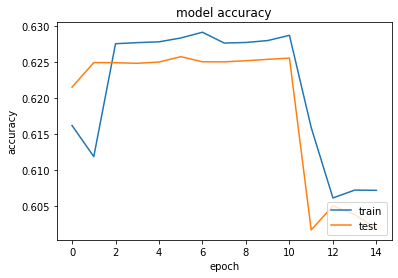

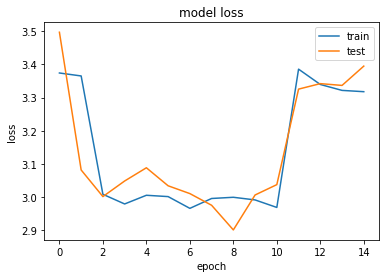

In [ ]:
# summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
np.save(urljoin(source_path, 'save_model/machine_translation_rnn_history.npy'), history_rnn.history)

In [ ]:
history_rnn = np.load(urljoin(source_path, 'save_model/machine_translation_rnn_history.npy'), allow_pickle='TRUE').item()

#### **LSTM**

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vi_vocab_size, embedding_dim, input_length=vi_max_len, mask_zero=True))
model_lstm.add(LSTM(hidden_size))
model_lstm.add(RepeatVector(en_max_len))
model_lstm.add(LSTM(hidden_size, return_sequences=True))
model_lstm.add(TimeDistributed(Dense(en_vocab_size, activation='softmax')))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           3211000   
                                                                 
 lstm (LSTM)                 (None, 256)               467968    
                                                                 
 repeat_vector (RepeatVector  (None, 50, 256)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 50, 256)           525312    
                                                                 
 time_distributed (TimeDistr  (None, 50, 36295)        9327815   
 ibuted)                                                         
                                                                 
Total params: 13,532,095
Trainable params: 13,532,095


In [ ]:
file_name = urljoin(source_path, 'save_model/machine_translation_lstm.h5')
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history_lstm = model_lstm.fit(generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, en_valid_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint]
                            )

Epoch 1/15
364/364 [==============================] - ETA: 0s - loss: 3.3484 - accuracy: 0.6048
Epoch 1: val_loss improved from inf to 2.77896, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_lstm.h5
364/364 [==============================] - 805s 2s/step - loss: 3.3484 - accuracy: 0.6048 - val_loss: 2.7790 - val_accuracy: 0.6215
Epoch 2/15
364/364 [==============================] - ETA: 0s - loss: 2.6293 - accuracy: 0.6269
Epoch 2: val_loss improved from 2.77896 to 2.58108, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_lstm.h5
364/364 [==============================] - 807s 2s/step - loss: 2.6293 - accuracy: 0.6269 - val_loss: 2.5811 - val_accuracy: 0.6317
Epoch 3/15
364/364 [==============================] - ETA: 0s - loss: 2.5476 - accuracy: 0.6358
Epoch 3: val_loss improved from 2.58108 to 2.55899, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insig

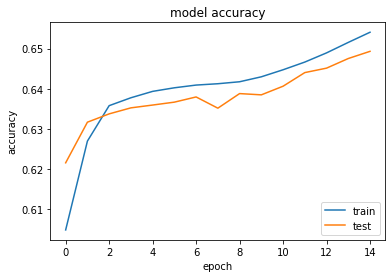

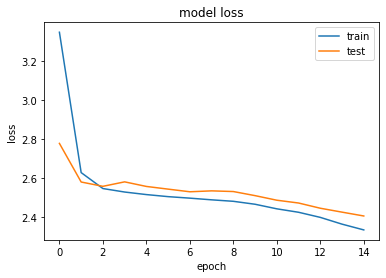

In [ ]:
# summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
np.save(urljoin(source_path, 'save_model/machine_translation_lstm_history.npy'), history_lstm.history)

In [ ]:
history_lstm = np.load(urljoin(source_path, 'save_model/machine_translation_lstm_history.npy'), allow_pickle='TRUE').item()

#### **GRU**

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(vi_vocab_size, embedding_dim, input_length=vi_max_len, mask_zero=True))
model_gru.add(GRU(hidden_size))
model_gru.add(RepeatVector(en_max_len))
model_gru.add(GRU(hidden_size, return_sequences=True))
model_gru.add(TimeDistributed(Dense(en_vocab_size, activation='softmax')))

model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 200)           3211000   
                                                                 
 gru (GRU)                   (None, 256)               351744    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 50, 256)          0         
 or)                                                             
                                                                 
 gru_1 (GRU)                 (None, 50, 256)           394752    
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 36295)        9327815   
 tributed)                                                       
                                                                 
Total params: 13,285,311
Trainable params: 13,285,311


In [ ]:
file_name = urljoin(source_path, 'save_model/machine_translation_gru.h5')
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history_gru = model_gru.fit(generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, en_valid_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint]
                            )

Epoch 1/15
364/364 [==============================] - ETA: 0s - loss: 3.1362 - accuracy: 0.6129
Epoch 1: val_loss improved from inf to 2.62111, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_gru.h5
364/364 [==============================] - 1034s 3s/step - loss: 3.1362 - accuracy: 0.6129 - val_loss: 2.6211 - val_accuracy: 0.6229
Epoch 2/15
364/364 [==============================] - ETA: 0s - loss: 2.5640 - accuracy: 0.6329
Epoch 2: val_loss improved from 2.62111 to 2.56508, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_gru.h5
364/364 [==============================] - 1149s 3s/step - loss: 2.5640 - accuracy: 0.6329 - val_loss: 2.5651 - val_accuracy: 0.6332
Epoch 3/15
364/364 [==============================] - ETA: 0s - loss: 2.5318 - accuracy: 0.6369
Epoch 3: val_loss improved from 2.56508 to 2.56035, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insig

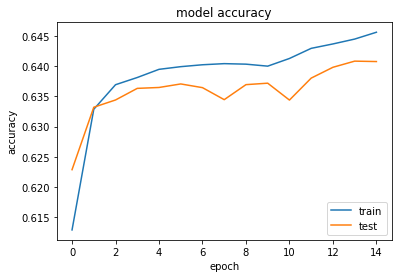

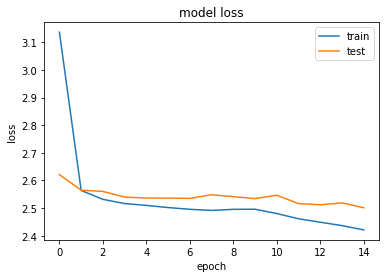

In [ ]:
# summarize history for accuracy
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_gru_history.npy', history_gru.history)

In [ ]:
history_gru = np.load('/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_gru_history.npy', allow_pickle='TRUE').item()

#### **Bi-GRU**

In [ ]:
model_bigru = Sequential()
model_bigru.add(Embedding(vi_vocab_size, embedding_dim, input_length=vi_max_len, mask_zero=True))
model_bigru.add(Bidirectional(GRU(hidden_size)))
model_bigru.add(RepeatVector(en_max_len))
model_bigru.add(Bidirectional(GRU(hidden_size, return_sequences=True)))
model_bigru.add(TimeDistributed(Dense(en_vocab_size, activation='softmax')))

model_bigru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bigru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 200)           3211000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              703488    
 nal)                                                            
                                                                 
 repeat_vector_2 (RepeatVect  (None, 50, 512)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 512)          1182720   
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 36295)        18619335  
 tributed)                                            

In [ ]:
file_name = '/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_bigru.h5'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history_bigru = model_bigru.fit(generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, en_valid_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint]
                            )

Epoch 1/15
364/364 [==============================] - ETA: 0s - loss: 2.9627 - accuracy: 0.6214
Epoch 1: val_loss improved from inf to 2.62798, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_bigru.h5
364/364 [==============================] - 1046s 3s/step - loss: 2.9627 - accuracy: 0.6214 - val_loss: 2.6280 - val_accuracy: 0.6305
Epoch 2/15
364/364 [==============================] - ETA: 0s - loss: 2.5888 - accuracy: 0.6359
Epoch 2: val_loss improved from 2.62798 to 2.59996, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_bigru.h5
364/364 [==============================] - 1226s 3s/step - loss: 2.5888 - accuracy: 0.6359 - val_loss: 2.6000 - val_accuracy: 0.6357
Epoch 3/15
364/364 [==============================] - ETA: 0s - loss: 2.5713 - accuracy: 0.6390
Epoch 3: val_loss improved from 2.59996 to 2.59117, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_big

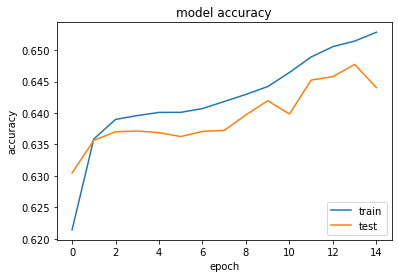

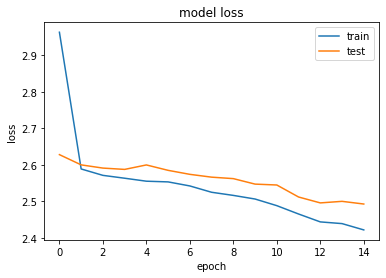

In [ ]:
# summarize history for accuracy
plt.plot(history_bigru.history['accuracy'])
plt.plot(history_bigru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_bigru.history['loss'])
plt.plot(history_bigru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_bigru_history.npy', history_bigru.history)

In [ ]:
history_bigru.history = np.load('/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_bigru_history.npy', allow_pickle='TRUE').item()

#### **Stacked GRU**

In [ ]:
model_stackedgru = Sequential()
model_stackedgru.add(Embedding(vi_vocab_size, embedding_dim, input_length=vi_max_len, mask_zero=True))
model_stackedgru.add(GRU(hidden_size, return_sequences=True))
model_stackedgru.add(GRU(hidden_size))
model_stackedgru.add(RepeatVector(en_max_len))
model_stackedgru.add(GRU(hidden_size, return_sequences=True))
model_stackedgru.add(GRU(hidden_size, return_sequences=True))
model_stackedgru.add(TimeDistributed(Dense(en_vocab_size, activation='softmax')))

model_stackedgru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_stackedgru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 200)           3211000   
                                                                 
 gru_4 (GRU)                 (None, 50, 256)           351744    
                                                                 
 gru_5 (GRU)                 (None, 256)               394752    
                                                                 
 repeat_vector (RepeatVector  (None, 50, 256)          0         
 )                                                               
                                                                 
 gru_6 (GRU)                 (None, 50, 256)           394752    
                                                                 
 gru_7 (GRU)                 (None, 50, 256)           394752    
                                                      

In [ ]:
file_name = '/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_stackedgru.h5'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history_stackedgru = model_stackedgru.fit(generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, en_valid_padded_seqs, batch_size = batch_size, vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint]
                            )

Epoch 1/15
364/364 [==============================] - ETA: 0s - loss: 3.1884 - accuracy: 0.6122
Epoch 1: val_loss improved from inf to 2.67388, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_stackedgru.h5
364/364 [==============================] - 813s 2s/step - loss: 3.1884 - accuracy: 0.6122 - val_loss: 2.6739 - val_accuracy: 0.6215
Epoch 2/15
364/364 [==============================] - ETA: 0s - loss: 2.6049 - accuracy: 0.6272
Epoch 2: val_loss improved from 2.67388 to 2.58792, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/nmt_stackedgru.h5
364/364 [==============================] - 825s 2s/step - loss: 2.6049 - accuracy: 0.6272 - val_loss: 2.5879 - val_accuracy: 0.6285
Epoch 3/15
364/364 [==============================] - ETA: 0s - loss: 2.5564 - accuracy: 0.6325
Epoch 3: val_loss did not improve from 2.58792
364/364 [==============================] - 839s 2s/step - loss: 2.5564 - accuracy: 0.6325 -

In [ ]:
np.save('/content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_stackedgru_history.npy', history_stackedgru.history)

### 4.Compare RNN, LSTM, GRU, Bi-GRU, Stacked GRU

In [ ]:
def load_history(source_path, metric):
    history_rnn = np.load(urljoin(source_path, 'save_model/machine_translation_rnn_history.npy'), allow_pickle='TRUE').item()
    history_lstm = np.load(urljoin(source_path, 'save_model/machine_translation_lstm_history.npy'), allow_pickle='TRUE').item()
    history_gru = np.load(urljoin(source_path, 'save_model/machine_translation_gru_history.npy'), allow_pickle='TRUE').item()
    history_bigru = np.load(urljoin(source_path, 'save_model/machine_translation_bigru_history.npy'), allow_pickle='TRUE').item()
    history_stackedgru = np.load(urljoin(source_path, 'save_model/machine_translation_stackedgru_history.npy'), allow_pickle='TRUE').item()

    plt.plot(history_rnn[metric])
    plt.plot(history_lstm[metric])
    plt.plot(history_gru[metric])
    plt.plot(history_bigru[metric])
    plt.plot(history_stackedgru[metric])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['RNN', 'LSTM', 'GRU', 'Bi-GRU', 'Stacked-GRU'], loc='lower right')
    plt.show()

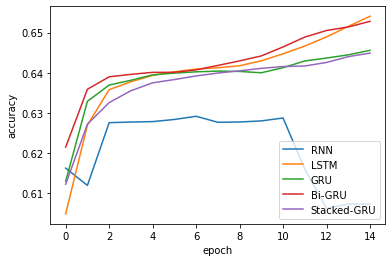

In [ ]:
load_history(source_path, 'accuracy')

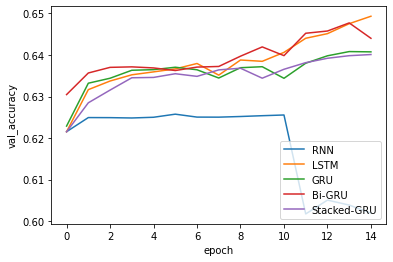

In [ ]:
load_history(source_path, 'val_accuracy')

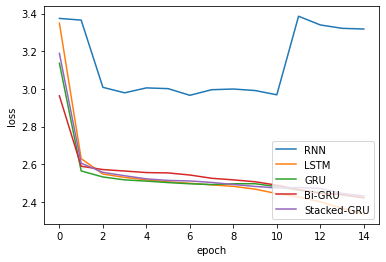

In [ ]:
load_history(source_path, 'loss')

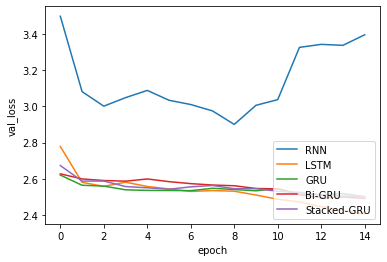

In [ ]:
load_history(source_path, 'val_loss')

### 5.Encoder-Decoder

In [ ]:
df

,vi,en,type_data
0,startseq lúc đó ngồi cạnh tôi là một học sinh ...,startseq and in the seat next to me was a high...,train
1,startseq và tôi nghĩ theo thời gian những năm ...,startseq and i think with time in the years to...,train
2,startseq liệu có đúng không nếu đánh giá một n...,startseq is not the measure of a man his willi...,train
3,startseq đèn đỏ giao thông có bảng đếm ngược e...,startseq red traffic lights have a countdown d...,train
4,startseq nhưng làm sao chúng làm được điều đó ...,startseq but how do we do that endseq,train
...,...,...,...
133313,startseq cho phép tôi tinh giảm điều này tới m...,startseq and let me reduce this to the simples...,test
133314,startseq các bạn đều biết twitter và các phiên...,startseq you know twitter and twitter clones h...,test
133315,startseq nguồn tài chính quan trọng không kém ...,startseq the supply of money — just as importa...,test
133316,startseq ở tuổi tôi đã tuyển những người từ đạ...,startseq at the age of i was recruiting people...,test


In [ ]:
df.vi = df.vi.apply(lambda x: " ".join(x.split()[1:-1]))

In [ ]:
df

,vi,en,type_data
0,lúc đó ngồi cạnh tôi là một học sinh cấp một t...,startseq and in the seat next to me was a high...,train
1,và tôi nghĩ theo thời gian những năm tới chúng...,startseq and i think with time in the years to...,train
2,liệu có đúng không nếu đánh giá một người đàn ...,startseq is not the measure of a man his willi...,train
3,đèn đỏ giao thông có bảng đếm ngược,startseq red traffic lights have a countdown d...,train
4,nhưng làm sao chúng làm được điều đó,startseq but how do we do that endseq,train
...,...,...,...
133313,cho phép tôi tinh giảm điều này tới mức đơn gi...,startseq and let me reduce this to the simples...,test
133314,các bạn đều biết twitter và các phiên bản nhái...,startseq you know twitter and twitter clones h...,test
133315,nguồn tài chính quan trọng không kém thậm chí ...,startseq the supply of money — just as importa...,test
133316,ở tuổi tôi đã tuyển những người từ đại học cam...,startseq at the age of i was recruiting people...,test


In [ ]:
vi_train, en_train = df[df.type_data == "train"].vi, df[df.type_data == "train"].en
vi_valid, en_valid = df[df.type_data == "valid"].vi, df[df.type_data == "valid"].en
vi_test, en_test = df[df.type_data == "test"].vi, df[df.type_data == "test"].en

#### Feature Extraction

In [ ]:
vi_max_len = 100
en_max_len = 80

**Encoder input data**

In [ ]:
vi_tokenizer = Tokenizer(oov_token = '<OOV>')
vi_tokenizer.fit_on_texts(vi_train)
vi_word_dict = vi_tokenizer.word_index
vi_vocab_size = len(vi_word_dict) + 1
vi_vocab_size

16055

In [ ]:
vi_train_padded_seqs = encode_sequences(vi_tokenizer, vi_max_len, vi_train)
vi_valid_padded_seqs = encode_sequences(vi_tokenizer, vi_max_len, vi_valid)
vi_train_padded_seqs.shape, vi_valid_padded_seqs.shape

((93322, 100), (19998, 100))

**Decoder input and output data**
- Example:
    - encoder input: "tôi yêu bạn"
    - decoder input: "startseq i love you endseq"
    - decoder output: "i love you endseq"
1. Remove "startseq" token from english corpus
2. Padding
3. Convert to one hot encoding

In [ ]:
en_tokenizer = Tokenizer(oov_token = '<OOV>')
en_tokenizer.fit_on_texts(en_train)
en_word_dict = en_tokenizer.word_index
en_vocab_size = len(en_tokenizer.index_word) + 1
en_vocab_size

36256

In [ ]:
en_train_padded_seqs, en_train_output_padded_seqs = encode_sequences(en_tokenizer, en_max_len, en_train, True)
en_valid_padded_seqs, en_valid_output_padded_seqs = encode_sequences(en_tokenizer, en_max_len, en_valid, True)
en_train_padded_seqs.shape, en_valid_padded_seqs.shape, en_train_output_padded_seqs.shape, en_valid_output_padded_seqs.shape

((93322, 80), (19998, 80), (93322, 80), (19998, 80))

In [ ]:
en_train_padded_seqs

array([[   2,    5,   12, ...,    0,    0,    0],
       [   2,    5,   11, ...,    0,    0,    0],
       [   2,    8,   18, ...,    0,    0,    0],
       ...,
       [   2,   38,   17, ...,    0,    0,    0],
       [   2,   15,   20, ...,    0,    0,    0],
       [   2,   13, 3205, ...,    0,    0,    0]], dtype=int32)

In [ ]:
en_train_output_padded_seqs

array([[    5,    12,     4, ...,     0,     0,     0],
       [    5,    11,    69, ...,     0,     0,     0],
       [    8,    18,     4, ...,     0,     0,     0],
       ...,
       [   38,    17,   722, ...,     0,     0,     0],
       [   15,    20,     6, ...,     0,     0,     0],
       [   13,  3205, 36253, ...,     0,     0,     0]], dtype=int32)

In [ ]:
def generate_encode_batch(src_input_seqs, tgt_input_seqs, tgt_output_seqs, batch_size, en_vocab_size):
    while True:
        for j in range(0, len(src_input_seqs), batch_size):
            src_input_seq = src_input_seqs[j:j+batch_size]
            tgt_input_seq = tgt_input_seqs[j:j+batch_size]
            tgt_output_seq = tgt_output_seqs[j:j+batch_size]
            tgt_output_seq = encode_outputs(tgt_output_seq, en_vocab_size)

            src_input_seq = np.array(src_input_seq)
            tgt_input_seq = np.array(tgt_input_seq)
            tgt_output_seq = np.array(tgt_output_seq)
            yield ([src_input_seq, tgt_input_seq], tgt_output_seq)

In [ ]:
encode_batch = generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, en_train_output_padded_seqs, batch_size, en_vocab_size)

In [ ]:
next(iter(encode_batch))[0][0].shape, next(iter(encode_batch))[0][1].shape, next(iter(encode_batch))[1].shape

((128, 100), (128, 80), (128, 80, 36256))

#### Seq2Seq Model

In [ ]:
embedding_dim = 200
hidden_size = 256
batch_size = 128
epochs = 15
train_samples = len(vi_train_padded_seqs)
val_samples = len(vi_valid_padded_seqs)

In [ ]:
encoder_inputs = Input(shape=(vi_max_len,))
encoder_embedding = Embedding(vi_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_size, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(en_max_len,))
decoder_embedding = Embedding(en_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(en_vocab_size, activation="softmax") 
output = decoder_dense(decoder_outputs)

seq2seq_model = Model([encoder_inputs, decoder_inputs], output )
seq2seq_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     3211000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 80, 200)      7251200     ['input_2[0][0]']                
                                                                                              

In [ ]:
file_name = urljoin(source_path, 'save_model/machine_translation_seq2seq.h5')
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history_seq2seq = seq2seq_model.fit(generate_encode_batch(vi_train_padded_seqs, en_train_padded_seqs, en_train_output_padded_seqs, batch_size = batch_size, en_vocab_size=en_vocab_size),
                            steps_per_epoch = train_samples//batch_size,
                            epochs=epochs,
                            validation_data = generate_encode_batch(vi_valid_padded_seqs, en_valid_padded_seqs, en_valid_output_padded_seqs, batch_size = batch_size, en_vocab_size=en_vocab_size),
                            validation_steps = val_samples//batch_size,
                            callbacks=[checkpoint]
                            )

Epoch 1/15
729/729 [==============================] - ETA: 0s - loss: 1.4807 - accuracy: 0.1431
Epoch 1: val_loss improved from inf to 1.32884, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_seq2seq.h5
729/729 [==============================] - 915s 1s/step - loss: 1.4807 - accuracy: 0.1431 - val_loss: 1.3288 - val_accuracy: 0.2094
Epoch 2/15
729/729 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.2328
Epoch 2: val_loss improved from 1.32884 to 1.22908, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio_insight/03_rnn/save_model/machine_translation_seq2seq.h5
729/729 [==============================] - 895s 1s/step - loss: 1.2562 - accuracy: 0.2328 - val_loss: 1.2291 - val_accuracy: 0.2561
Epoch 3/15
729/729 [==============================] - ETA: 0s - loss: 1.1660 - accuracy: 0.2725
Epoch 3: val_loss improved from 1.22908 to 1.16884, saving model to /content/drive/MyDrive/AI_VIETNAM/Course/aio

#### Inference

In [ ]:
def get_inference_models():
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [ ]:
encoder_model , decoder_model = get_inference_models()

encoder_model.save(urljoin(source_path, 'save_model/machine_translation_seq2seq_encoder.h5')) 
decoder_model.save(urljoin(source_path, 'save_model/machine_translation_seq2seq_decoder.h5'))

enc_model = load_model(urljoin(source_path, 'save_model/machine_translation_seq2seq_encoder.h5')) 
dec_model = load_model(urljoin(source_path, 'save_model/machine_translation_seq2seq_decoder.h5'))

### 6.Prediction

In [ ]:
def nmt_predict_seq2seq(text):
    states_values = encoder_model.predict(encode_sequences(vi_tokenizer, vi_max_len, corpus=[text]))
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = en_tokenizer.word_index['startseq']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = decoder_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in en_tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
            
        if sampled_word == 'endseq' or len(decoded_translation.split()) > en_max_len:
            stop_condition = True
                
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ]
    return " ".join(decoded_translation.split()[:-1])

In [ ]:
def nmt_predict(test_sentence, vi_tokenizer, vi_max_len, model, en_tokenizer):
    vi_test_padded_seq = encode_sequences(vi_tokenizer, vi_max_len, [test_sentence])
    vi_test_padded_seq = vi_test_padded_seq.reshape(1, vi_max_len)
    predict_seqs = model.predict(vi_test_padded_seq)

    predict_sentence = []
    for seq in predict_seqs[0]:
        idx = np.argmax(seq)
        if idx not in [0, 1]:
            word = en_tokenizer.index_word[idx]
            predict_sentence.append(word)
        elif idx == 3:
            break
    return " ".join([word for word in predict_sentence if word not in ["startseq", "endseq"]])

In [ ]:
def evaluate(src, tgt, model=None):
    if model != None:
        predict_seqs = nmt_predict(src, vi_tokenizer, vi_max_len, model, en_tokenizer)
        src = " ".join(src.split()[1:-1])
    else:
        predict_seqs = nmt_predict_seq2seq(src)
    tgt = " ".join(tgt.split()[1:-1])
    print("SRC: ", src)
    print("REFERENCE: ", tgt)
    print("PREDICT: ", predict_seqs)

    print('BLEU-1: %f' % sentence_bleu([predict_seqs.split()], tgt.split(), weights=(1., 0, 0, 0)))
    # print('BLEU-2: %f' % sentence_bleu([predict_seqs.split()], tgt.split(), weights=(0.5, 0.5, 0, 0)))
    # print('BLEU-3: %f' % sentence_bleu([predict_seqs.split()], tgt.split(), weights=(0.3, 0.3, 0.3, 0)))
    # print('BLEU-4: %f' % sentence_bleu([predict_seqs.split()], tgt.split(), weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
model_rnn =load_model(urljoin(source_path, 'save_model/machine_translation_rnn.h5'))
model_lstm =load_model(urljoin(source_path, 'save_model/machine_translation_lstm.h5'))
model_gru =load_model(urljoin(source_path, 'save_model/machine_translation_gru.h5'))
model_bigru =load_model(urljoin(source_path, 'save_model/machine_translation_bigru.h5'))
model_stackedgru =load_model(urljoin(source_path, 'save_model/machine_translation_stackedgru.h5'))

In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0])

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and when i came back to the next time i thought you are going to go to school
BLEU-1: 0.190476


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2])

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank you
BLEU-1: 1.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0], model_rnn)

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and
BLEU-1: 0.047619


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2], model_rnn)

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank
BLEU-1: 0.500000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0], model_lstm)

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and when i to to i i i i i i
BLEU-1: 0.142857


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2], model_lstm)

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank you
BLEU-1: 1.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0], model_gru)

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and i i i i i i i i you you
BLEU-1: 0.095238


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2], model_gru)

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank you
BLEU-1: 1.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0], model_bigru)

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and then i i i i i i i i i i i
BLEU-1: 0.095238


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2], model_bigru)

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank you
BLEU-1: 1.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[0], list(df[df.type_data == "test"].en)[0], model_stackedgru)

SRC:  và khi chúng tôi mới gặp nhau tôi nhớ anh ấy đã đưa tôi đi hẹn hò
REFERENCE:  and when we first met one of the things that i remember is that he took me out on a date
PREDICT:  and i i apos i i i i i to to to
BLEU-1: 0.095238


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate(list(df[df.type_data == "test"].vi)[2], list(df[df.type_data == "test"].en)[2], model_stackedgru)

SRC:  cảm ơn
REFERENCE:  thank you
PREDICT:  thank you
BLEU-1: 1.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### 7.Evaluate Test Set

In [ ]:
def blue_score_test_set():
    blue_1 = []
    for idx, (src, tgt) in enumerate(zip(list(vi_test), list(en_test))):
        print(idx)
        # print(src, tgt)
        predict_seqs = nmt_predict_seq2seq(src)
        blue_score = sentence_bleu([predict_seqs.split()], tgt.split(), weights=(1., 0, 0, 0))
        blue_1.append(blue_score)
    return sum(blue_1)/len(blue_1)
blue_score_test_set()